In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import glob 
import random
from PIL import Image
from tqdm import tqdm
import kagglehub
import os
import matplotlib.pyplot as plt

device = torch.device("cpu")

In [8]:
# Download latest version
data_dir = kagglehub.dataset_download("alessiocorrado99/animals10")
data_dir = os.path.join(data_dir, 'raw-img')
print("Path to dataset files:", data_dir)

classes = { "cane": "dog",
            "cavallo": "horse",
            "elefante": "elephant",
            "farfalla": "butterfly",
            "gallina": "chicken", 
            "gatto": "cat",
            "mucca": "cow",
            "pecora": "sheep",
            "scoiattolo": "squirrel",
            "dog": "cane", 
            "cavallo": "horse",
            "elephant" : "elefante",
            "butterfly": "farfalla",
            "chicken": "gallina",
            "cat": "gatto", 
            "cow": "mucca",
            "spider": "ragno",
            "squirrel": "scoiattolo"}
data = {
    "path":[],
    "label":[]
}

for label_it,label_en in classes.items():
    paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')

    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

Path to dataset files: C:\Users\zeesh\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img


,path,label
0,C:\Users\zeesh\.cache\kagglehub\datasets\aless...,dog
1,C:\Users\zeesh\.cache\kagglehub\datasets\aless...,dog
2,C:\Users\zeesh\.cache\kagglehub\datasets\aless...,dog
3,C:\Users\zeesh\.cache\kagglehub\datasets\aless...,dog
4,C:\Users\zeesh\.cache\kagglehub\datasets\aless...,dog


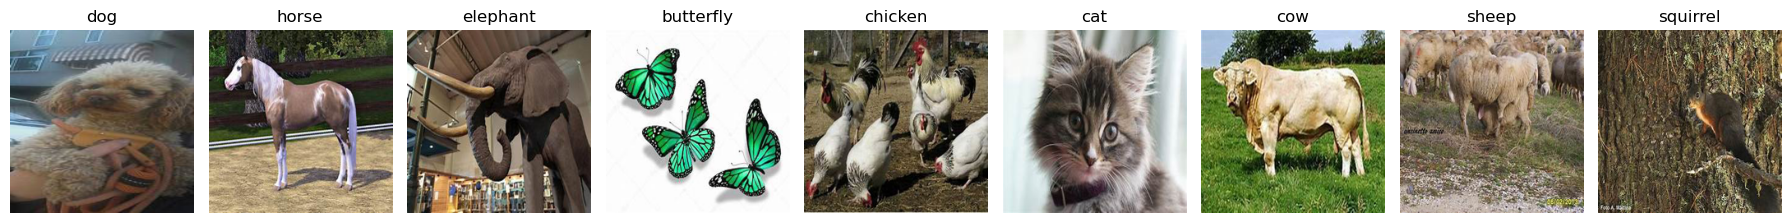

In [10]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Resize function to load images in smaller size
def load_and_resize_image(image_path, size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(size)
    return img

# Subset the dataset for fewer images per class (e.g., 5 images per label)
num_images_per_label = 5

plt.figure(figsize=(20, 7))

for idx, i in enumerate(df_data.label.unique()):
    plt.subplot(1, 10, idx + 1)

    # Filter dataset by label
    df = df_data[df_data['label'] == i].reset_index(drop=True)

    # Select a random subset of images for each label
    random_subset = df.sample(n=min(num_images_per_label, len(df)), random_state=42)

    # Select a random image from the subset using iloc
    random_index = random.randint(0, len(random_subset) - 1)
    image_path = random_subset.iloc[random_index]['path']

    # Load and resize the selected image
    img = load_and_resize_image(image_path, size=(224, 224))

    plt.imshow(img)
    plt.axis('off')
    plt.title(i)

plt.tight_layout()
plt.show()


In [12]:
# transform = transforms.Compose([
#      transforms.Resize((224,224)),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

transform = transforms.Compose([
     transforms.Resize((128, 128)),
     transforms.RandomHorizontalFlip(),  # Lightweight augmentation
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Dataset = datasets.ImageFolder(root=data_dir, transform=transform)
# Print the number of classes
num_classes = len(Dataset.classes)
print(f"Number of classes: {num_classes}")

# Print the number of samples
num_samples = len(Dataset)
print(f"Number of samples: {num_samples}")

train_size = int(0.8 * len(Dataset))  # 80% for training
test_size = len(Dataset) - train_size  # 20% for testing
# split dataset
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

# Create data loaders for the train and test datasets
batch_size = 32  # You can adjust this value as needed
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


Number of classes: 10
Number of samples: 26179


In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)

# Train the model
total_step = len(train_loader)

In [16]:
import gc
import torch

total_step = len(train_loader)

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}...")

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Release memory and perform garbage collection
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

        if (i + 1) % 100 == 0:  # Print every 100 steps to track progress
            print(f"Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Final Loss: {loss.item():.4f}")

    # Validation
    print("Validating the model on the test set...")
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            del images, labels, outputs

        accuracy = 100 * correct / total
        print(f"Accuracy on the validation set: {accuracy:.2f}%")

    print(f"Finished epoch {epoch+1}/{num_epochs}.")


Starting epoch 1/10...


RuntimeError: Given input size: (512x4x4). Calculated output size: (512x-2x-2). Output size is too small